## Passionate Investors and Cyberpunks. ERC20 Analysis

In [1]:
import pandas as pd
from math import log10
from tqdm.notebook import tqdm_notebook

from config import PROJECT_ID, INITIAL_TS, SNAPSHOT_TS, \
    ETH_ANALYSIS_DATASET_NAME, ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    ERC20_ANALYSIS_DATASET_NAME, ERC20_ROW_BALANCES_TABLE_NAME, ERC20_REVISED_BALANCES_TABLE_NAME, \
    ERC20_BALANCES_TABLE_NAME, ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME, ERC20_TOKEN_METADATA_TABLE_NAME, \
    STABLECOINS_LOVERS_TABLE_NAME, INVESTORS_AUDIENCE, CYBERPUNKS_AUDIENCE
from src.utils_bigquery import drop_table, create_table, create_table_from_df, get_df
from src.utils_charts import grade_boundaries_analysis
from src.extractor_balances import get_balances

DROP_TABLES = True
CREATE_TABLES = True
REVISE_TOKEN_BALANCES = False

In [2]:
investors_min_number_of_tokens = 2
erc20_balance_initial_boundary = 0.01

erc20_tokens_dict = {
    # name:           [address,                                      type,         ETH price,  decimals]
    'YFI':            ['0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e', 'investment', 7.6,       18],
    'FTM':            ['0x4e15361fd6b4bb609fa63c81a2be19d873717870', 'investment', 0.00064,   18],
    'AMPL':           ['0xd46ba6d942050d489dbd938a2c909a5d5039a161', 'investment', 0.00034,    9],
    'renBTC':         ['0xeb4c2781e4eba804ce9a9803c67d0893436bb27d', 'investment', 13.8,       8],
    'OCEAN':          ['0x967da4048cd07ab37855c090aaf366e4ce1b9f48', 'investment', 0.000215,  18],
    'RPL':            ['0xb4efd85c19999d84251304bda99e90b92300bd93', 'investment', 0.012,     18],
    'UNI':            ['0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'investment', 0.0057,    18],
    'KEEP3R':         ['0x1ceb5cb57c4d4e2b2433641b95dd330a33185a44', 'investment', 0.072,     18],
    'GST2':           ['0x0000000000b3f879cb30fe243b4dfee438691c04', 'investment', 0.017,      2],
    'CHI':            ['0x0000000000004946c0e9f43f4dee607b0ef1fa1c', 'investment', 0.0007,     0],
    'MLN':            ['0xec67005c4e498ec7f55e092bd1d35cbc47c91892', 'investment', 0.031,     18],
    'AAVE':           ['0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9', 'investment', 0.076,     18],
    'GLM':            ['0x7dd9c5cba05e151c895fde1cf355c9a1d5da6429', 'investment', 0.000126,  18],
    'ZRX':            ['0xe41d2489571d322189246dafa5ebde1f4699f498', 'investment', 0.00026,   18],
    'SNX':            ['0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f', 'investment', 0.0023,    18],
    'SUSHI':          ['0x6b3595068778dd592e39a122f4f5a5cf09c90fe2', 'investment', 0.0028,    18],
    'COMP':           ['0xc00e94cb662c3520282e6f5717214004a7f26888', 'investment', 0.081,     18],
    'BAL':            ['0xba100000625a3754423978a60c9317c58a424e3d', 'investment', 0.0062,    18],
    'GRT':            ['0xc944e90c64b2c07662a292be6244bdf05cda44a7', 'investment', 0.00025,   18],
    'MKR':            ['0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2', 'investment', 0.64,      18],
    'CRV':            ['0xd533a949740bb3306d119cc777fa900ba034cd52', 'investment', 0.00091,   18],
    'LPT':            ['0x58b6a8a3302369daec383334672404ee733ab239', 'investment', 0.0075,    18],
    'ANT':            ['0xa117000000f279d81a1d3cc75430faa017fa5a2e', 'investment', 0.00114,   18],
    'GEN':            ['0x543ff227f64aa17ea132bf9886cab5db55dcaddf', 'investment', 0.0000137, 18],
    'PNK':            ['0x93ed3fbe21207ec2e8f2d3c3de6e058cb73bc04d', 'investment', 0.00003,   18],
    'REP':            ['0x221657776846890989a759ba2973e427dff5c9bb', 'investment', 0.0055,    18],
    'SNT':            ['0x744d70fdbe2ba4cf95131626614a1763df805b9e', 'investment', 0.000021,  18],
    '2KEY':           ['0xE48972fCd82a274411c01834e2f031D4377Fa2c0', 'investment', 0.0000036, 18],
    'NU':             ['0x4fE83213D56308330EC302a8BD641f1d0113A4Cc', 'investment', 0.0002,    18],
    'MANA':           ['0x0f5d2fb29fb7d3cfee444a200298f468908cc942', 'investment', 0.00056,   18],
    'TORN':           ['0x77777feddddffc19ff86db637967013e6c6a116c', 'investment', 0.013,     18],
    'XRT':            ['0x7de91b204c1c737bcee6f000aaa6569cf7061cb7', 'investment', 0.0043,     9],
    'FOAM':           ['0x4946fcea7c692606e8908002e55a582af44ac121', 'cyberpunk',  0.000015,  18],
    'GOLD':           ['0x150b0b96933b75ce27af8b92441f8fb683bf9739', 'cyberpunk',  0.000007,  18],
    'Tether':         ['0xdac17f958d2ee523a2206206994597c13d831ec7', 'stablecoin', 0.00022,    6],
    'USD Coin':       ['0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 'stablecoin', 0.00022,    6],
    'Binance USD':    ['0x4fabb145d64652a948d72533023f6e7a623c7c53', 'stablecoin', 0.00022,   18],
    'DAI':            ['0x6b175474e89094c44da98b954eedeac495271d0f', 'stablecoin', 0.00022,   18],
    'Fei Protocol':   ['0x956f47f50a910163d8bf957cf5846d573e7f87ca', 'stablecoin', 0.00022,   18],
    'TerraUSD':       ['0xa47c8bf37f92abed4a126bda807a7b7498661acd', 'stablecoin', 0.00022,   18],
    'Liquity USD':    ['0x5f98805a4e8be255a32880fdec7f6728c6568ba0', 'stablecoin', 0.00022,   18],
    'Paxos Standard': ['0x8e870d67f660d95d5be530380d0ec0bd388289e1', 'stablecoin', 0.00022,   18],
    'TrueUSD':        ['0x0000000000085d4780b73119b644ae5ecd22b376', 'stablecoin', 0.00022,   18],
    'HUSD':           ['0xdf574c24545e5ffecb9a659c229253d4111d87e1', 'stablecoin', 0.00022,    8],
    'Neutrino USD':   ['0x674c6ad92fd080e4004b2312b45f796a192d27a0', 'stablecoin', 0.00022,   18],
    'sUSD':           ['0x57ab1ec28d129707052df4df418d58a2d46d5f51', 'stablecoin', 0.00022,   18]
}

erc20_tokens_dict = {k: [v[0].lower(), v[1], v[2], v[3]] for k, v in erc20_tokens_dict.items()}
erc20_tokens_inverse_dict = {v[0].lower():k for k, v in erc20_tokens_dict.items()}


erc20_tokens_df = pd.DataFrame(erc20_tokens_dict.values(),
                               index=erc20_tokens_dict.keys(),
                               columns=['address', 'type', 'eth_price', 'decimals']).reset_index()

MINT_EVENT_HASH = '0x0f6798a560793a54c3bcfe86a93cde1e73087d944c0ea20544137d4121396885'
BURN_EVENT_HASH = '0xcc16f5dbb4873280815c1ee09dbd06736cffcc184412cf7a71a0fdb75d397ca5'

### Set Token Data

In [3]:
investors_erc20_tokens_addresses_tuple = tuple(erc20_tokens_df[erc20_tokens_df.type=='investment'].address.values.tolist())

cyberpunks_erc20_tokens_addresses_tuple = tuple(erc20_tokens_df[erc20_tokens_df.type=='cyberpunk'].address.values.tolist())

stablecoins_erc20_tokens_addresses_tuple = tuple(erc20_tokens_df[erc20_tokens_df.type=='stablecoin'].address.values.tolist())

erc20_tokens_addresses_tuple = investors_erc20_tokens_addresses_tuple + \
                               cyberpunks_erc20_tokens_addresses_tuple + \
                               stablecoins_erc20_tokens_addresses_tuple

### Create Token Metadata Table

In [4]:
if CREATE_TABLES:
    r = create_table_from_df(source_df=erc20_tokens_df,
                             table_name=ERC20_TOKEN_METADATA_TABLE_NAME,
                             dataset_name=ERC20_ANALYSIS_DATASET_NAME,
                             drop_existing_table=DROP_TABLES)
elif DROP_TABLES:
    drop_table(table_name=ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

Table erc20_analysis:erc20_token_metadata has been deleted.
Table erc20_analysis:erc20_token_metadata has been created.


### Get Balances

In [5]:
query_1 = f'''
    WITH incoming_transfers AS (
        SELECT
            transaction_hash,
            token_address,
            to_address as address,
            safe_cast(value as float64) as value
        FROM `bigquery-public-data.crypto_ethereum.token_transfers`
        WHERE token_address IN {erc20_tokens_addresses_tuple}
          AND to_address NOT IN ('0x0000000000000000000000000000000000000000')
          AND block_timestamp >= '{INITIAL_TS}'
          AND block_timestamp <= '{SNAPSHOT_TS}'
    ),
    outgoing_transfers AS (
        SELECT
            transaction_hash,
            token_address,
            from_address as address,
            - safe_cast(value as float64) as value
        FROM `bigquery-public-data.crypto_ethereum.token_transfers`
        WHERE token_address IN {erc20_tokens_addresses_tuple}
          AND from_address NOT IN ('0x0000000000000000000000000000000000000000')
          AND block_timestamp >= '{INITIAL_TS}'
          AND block_timestamp <= '{SNAPSHOT_TS}'
    ),
    mint_burn AS (
        SELECT
            transaction_hash,
            address as token_address,
            REPLACE(topics[ORDINAL(2)], '0x000000000000000000000000', '0x') as address,
            IF(topics[ORDINAL(1)] = '{MINT_EVENT_HASH}', 'mint', 'burn') as event_name,
            safe_cast(data AS float64) as value
        FROM `bigquery-public-data.crypto_ethereum.logs`
        WHERE block_timestamp >= '{INITIAL_TS}'
          AND block_timestamp <= '{SNAPSHOT_TS}'
          AND address IN {erc20_tokens_addresses_tuple}
          AND topics[ORDINAL(1)] IN ('{MINT_EVENT_HASH}', '{BURN_EVENT_HASH}')
    ),
    token_transfers AS (
        SELECT
            token_address,
            address,
            sum(value) as balance
        FROM (
            SELECT
                token_address,
                address,
                IF((mint_value > COALESCE(transfer_value, 0) * 1.01) OR (mint_value < COALESCE(transfer_value, 0) * 0.99), mint_value, 0) as value
            FROM (
                SELECT
                    transaction_hash,
                    token_address,
                    address,
                    sum(value) as mint_value
                FROM mint_burn
                WHERE event_name = 'mint'
                GROUP BY transaction_hash, token_address, address
                )
            LEFT JOIN (
                SELECT
                    transaction_hash,
                    token_address,
                    address,
                    sum(value) as transfer_value
                FROM incoming_transfers
                GROUP BY transaction_hash, token_address, address
                )
            USING (transaction_hash, token_address, address)

            UNION ALL

            SELECT
                token_address,
                address,
                value
            FROM incoming_transfers

            UNION ALL

            SELECT
                token_address,
                address,
                value
            FROM outgoing_transfers

            UNION ALL

            SELECT
                token_address,
                address,
                IF((burn_value < COALESCE(transfer_value, 0)*1.01) OR (burn_value > COALESCE(transfer_value, 0)*0.99), burn_value, 0) as value
            FROM (
                SELECT
                    transaction_hash,
                    token_address,
                    address,
                    - sum(value) as burn_value
                FROM mint_burn
                WHERE event_name = 'burn'
                GROUP BY transaction_hash, token_address, address
                )
            LEFT JOIN (
                SELECT
                    transaction_hash,
                    token_address,
                    address,
                    sum(value) as transfer_value
                FROM outgoing_transfers
                GROUP BY transaction_hash, token_address, address
                )
            USING (transaction_hash, token_address, address)
                )
        GROUP BY token_address, address
    )
    SELECT
        token_address,
        token_transfers.address as address,
        balance,
        token_metadata.eth_price as eth_price,
        token_metadata.decimals as decimals,
        balance * token_metadata.eth_price / pow(10, token_metadata.decimals) as eth_balance
    FROM token_transfers
    LEFT JOIN `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOKEN_METADATA_TABLE_NAME}` as token_metadata
    ON token_transfers.token_address = token_metadata.address
'''

if DROP_TABLES:
    drop_table(table_name=ERC20_ROW_BALANCES_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_1,
                 table_name=ERC20_ROW_BALANCES_TABLE_NAME,
                 dataset_name=ERC20_ANALYSIS_DATASET_NAME)

Table erc20_analysis:erc20_row_balances has been deleted.
Table erc20_analysis:erc20_row_balances has been created and filled 36,881,129 rows.


## Check Balances

In [6]:
query_2 = f'''
    SELECT
        token_address,
        SUM(IF(balance > 0, eth_balance, 0)) as eth_positive_balances,
        SUM(IF(balance < 0, - eth_balance, 0)) as eth_negative_balances,
        COUNTIF(balance > 0) as number_positive_balances,
        COUNTIF(balance = 0) as number_zero_balances,
        COUNTIF(balance < 0) as number_negative_balances
     FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_ROW_BALANCES_TABLE_NAME}`
     GROUP BY token_address
     HAVING eth_negative_balances > 0.01
        AND number_negative_balances > 5
     ORDER BY number_negative_balances DESC
'''
negative_balances_df = get_df(query_2)
print(f'Total addresses with negative balance {sum(negative_balances_df.number_negative_balances):>,}')
print(f'Total addresses with this tokens {sum(negative_balances_df.number_negative_balances) + sum(negative_balances_df.number_positive_balances):>,}')
negative_balances_df

Total addresses with negative balance 115,058
Total addresses with this tokens 567,637


,token_address,eth_positive_balances,eth_negative_balances,number_positive_balances,number_zero_balances,number_negative_balances
0,0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f,486327.865164,486327.865164,93079,181001,32042
1,0xe41d2489571d322189246dafa5ebde1f4699f498,259997.371286,259999.408946,214184,468830,26746
2,0xd46ba6d942050d489dbd938a2c909a5d5039a161,104109.182794,87109.182794,55951,20885,24610
3,0x0000000000085d4780b73119b644ae5ecd22b376,203177.919017,40563.990700,57700,150823,17789
4,0x57ab1ec28d129707052df4df418d58a2d46d5f51,27619.281294,511.411010,16429,18636,7015
5,0x1ceb5cb57c4d4e2b2433641b95dd330a33185a44,19534.757723,486.610719,8868,17317,3389
6,0x674c6ad92fd080e4004b2312b45f796a192d27a0,56319.242177,110.103777,1228,1603,2291
7,0xe48972fcd82a274411c01834e2f031d4377fa2c0,2159.952032,2159.952032,4203,3806,592
8,0x0000000000b3f879cb30fe243b4dfee438691c04,1017.647200,1017.647200,937,1129,584


## Revise Balances

In [7]:
if REVISE_TOKEN_BALANCES:
    revise_token_list = tuple(negative_balances_df['token_address'].values)
    revised_balances_df = pd.DataFrame(columns=('address', 'token_address', 'balance'))

    for revise_token in tqdm_notebook(revise_token_list):
        print(erc20_tokens_inverse_dict[revise_token], revise_token)
        balances_df = get_balances(token_address=revise_token, threads_number=15)
        revised_balances_df = revised_balances_df.append(balances_df)
        balances_df.to_csv('data/balances_'+erc20_tokens_inverse_dict[revise_token]+'.csv')

    revised_balances_df = revised_balances_df.astype({'balance': 'float'})

    if CREATE_TABLES:
        create_table_from_df(source_df=revised_balances_df,
                             table_name=ERC20_REVISED_BALANCES_TABLE_NAME,
                             dataset_name=ERC20_ANALYSIS_DATASET_NAME,
                             drop_existing_table=DROP_TABLES)

### Update Balances after Revising

In [8]:
query_3 = f'''
    WITH revised_tokens as (
        SELECT DISTINCT
            token_address
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_REVISED_BALANCES_TABLE_NAME}`
    ),
    balances as (
        SELECT
            address,
            token_address,
            balance
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_REVISED_BALANCES_TABLE_NAME}`

        UNION ALL

        SELECT
            address,
            token_address,
            balance
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_ROW_BALANCES_TABLE_NAME}`
        WHERE token_address NOT IN (SELECT token_address FROM revised_tokens)
           OR balance = 0
    )
    SELECT
        token_address,
        balances.address as address,
        balance,
        token_metadata.eth_price as eth_price,
        token_metadata.decimals as decimals,
        balance * token_metadata.eth_price / pow(10, token_metadata.decimals) as eth_balance
    FROM balances
    LEFT JOIN `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOKEN_METADATA_TABLE_NAME}`  as token_metadata
    ON balances.token_address = token_metadata.address
'''

if DROP_TABLES:
    drop_table(table_name=ERC20_BALANCES_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_3,
                 table_name=ERC20_BALANCES_TABLE_NAME,
                 dataset_name=ERC20_ANALYSIS_DATASET_NAME)

Table erc20_analysis:erc20_balances has been deleted.
Table erc20_analysis:erc20_balances has been created and filled 36,879,621 rows.


## Get Stablecoin Lovers

In [9]:
query_4 = f'''
    WITH erc20_balances AS (
        SELECT
            address,
            sum(selected_erc20_balance) as sum_selected_erc20_balance,
            sum(stablecoin_balance) as sum_stablecoin_balance
        FROM (
            SELECT
                address,
                if(token_address IN {investors_erc20_tokens_addresses_tuple + cyberpunks_erc20_tokens_addresses_tuple}, eth_balance, 0) as selected_erc20_balance,
                if(token_address IN {stablecoins_erc20_tokens_addresses_tuple}, eth_balance, 0) as stablecoin_balance
            FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_BALANCES_TABLE_NAME}`)
        GROUP BY address
        HAVING sum_stablecoin_balance > sum_selected_erc20_balance
           AND sum_stablecoin_balance > 0.1),
    eth_balances AS (
        SELECT
            address,
            eth_balance
        FROM `{PROJECT_ID}.{ETH_ANALYSIS_DATASET_NAME}.{ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
    )
    SELECT
        address,
        sum_selected_erc20_balance,
        sum_stablecoin_balance,
        eth_balance
    FROM erc20_balances
    LEFT JOIN eth_balances
    USING (address)
    WHERE sum_stablecoin_balance > sum_selected_erc20_balance + eth_balance
'''

if DROP_TABLES:
    drop_table(table_name=STABLECOINS_LOVERS_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_4,
                 table_name=STABLECOINS_LOVERS_TABLE_NAME,
                 dataset_name=ERC20_ANALYSIS_DATASET_NAME)

Table erc20_analysis:stablecoins_lovers has been deleted.
Table erc20_analysis:stablecoins_lovers has been created and filled 211,406 rows.


### Analysis of Grade Boundaries. ERC20 balance

In [10]:
query_5 = f'''
    SELECT
        if(round(sum_eth_balance, 1) < 0.1, 0.05, round(sum_eth_balance, 1)) as erc20_balance_class,
        count(address) as number_of_addresses
    FROM (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            sum(eth_balance) as sum_eth_balance
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_BALANCES_TABLE_NAME}`
        WHERE balance > {erc20_balance_initial_boundary}
            AND token_address IN {investors_erc20_tokens_addresses_tuple}
        GROUP BY address
        HAVING number_of_tokens >= {investors_min_number_of_tokens}
           AND sum_eth_balance > {erc20_balance_initial_boundary})
    GROUP BY erc20_balance_class
'''
distribution_by_erc20_balance_df = get_df(query_5)

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,0.01 < ERC20 Balance <= 3.0,196032,90.0
2,3.0 < ERC20 Balance <= 55.0,19649,9.0
3,55.0 < ERC20 Balance,2164,1.0


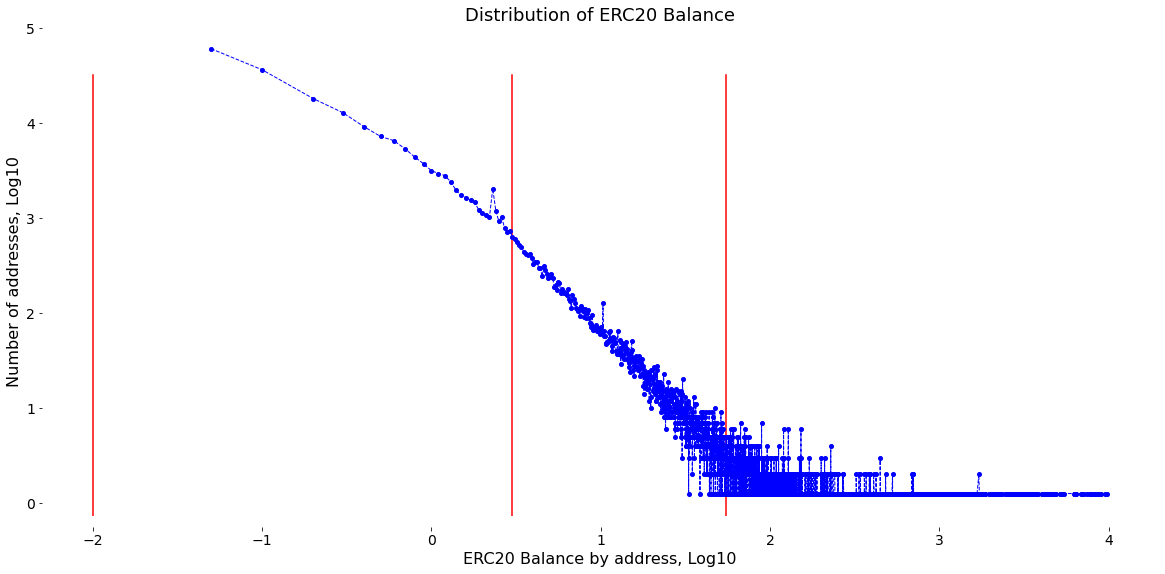

In [11]:
investors_boundary_erc20_balance = \
    grade_boundaries_analysis(
        distribution_df=distribution_by_erc20_balance_df,
        value_column = 'erc20_balance_class',
        value_chart_label = 'ERC20 Balance by address, Log10',
        value_name = 'ERC20 Balance',
        value_transform_func=lambda x: log10(x),
        chart_title = 'Distribution of ERC20 Balance',
        initial_boundary=erc20_balance_initial_boundary,
        max_show_value=10000,
        level_line_shift=0)

### Distribution Rules. Passionate Investors

<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Number of tokens >= 2 and ERC20 balance </td>
            <td> > 0.01 ETH </td>
            <td> > 3 ETH </td>
            <td> > 55 ETH </td>
        </tr>
    </tbody>
</table>

### Distribution Rule. Cyberpunks

<table style="text-align: left">
<thead style="text-align: center">
<tr>
<th rowspan=2></th>
<th colspan=3>Grade</th>
</tr>
<tr>
<th>1</th>
<th>2</th>
<th>3</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: left"> Owners of the Selected tokens </td>
<td> - </td>
<td> - </td>
<td> here </td>
</tr>
</tbody>
</table>

### Create Distribution Table

In [12]:
query_6 = f'''
    SELECT
        '{INVESTORS_AUDIENCE}' as audience,
        'ERC20 Balance' as segment,
        address,
        CASE
            WHEN sum_eth_balance > {investors_boundary_erc20_balance[2]} THEN 3
            WHEN sum_eth_balance > {investors_boundary_erc20_balance[1]} THEN 2
            WHEN sum_eth_balance > {investors_boundary_erc20_balance[0]} THEN 1
        END
        AS grade,
        sum_eth_balance,
        number_of_tokens
    FROM (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            sum(eth_balance) as sum_eth_balance
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_BALANCES_TABLE_NAME}`
        WHERE balance > 0
          AND token_address IN {investors_erc20_tokens_addresses_tuple}
        GROUP BY address)
    WHERE number_of_tokens >= {investors_min_number_of_tokens}

    UNION ALL

    SELECT
        '{CYBERPUNKS_AUDIENCE}' as audience,
        'Owners of the Selected ERC20 Tokens' as segment,
        address,
        3 AS grade,
        sum_eth_balance,
        number_of_tokens
    FROM (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            sum(eth_balance) as sum_eth_balance
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_BALANCES_TABLE_NAME}`
        WHERE balance > 0
          AND token_address IN {cyberpunks_erc20_tokens_addresses_tuple}
        GROUP BY address)
'''

if DROP_TABLES:
    drop_table(table_name=ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME,
               dataset_name=ERC20_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_6,
                 table_name=ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME,
                 dataset_name=ERC20_ANALYSIS_DATASET_NAME)


Table erc20_analysis:erc20_analysis_distribution has been deleted.
Table erc20_analysis:erc20_analysis_distribution has been created and filled 274,702 rows.
